In [24]:
import numpy as np
import random

class Q_maze():
    '''
    Resuelve laberintos empleando el algoritmo Q-Learning. Se consideran dos casos. El primer caso considera un laberinto compuestos por fosas, es decir, cuando el agente cae en una fosa se muere y finaliza el episodio, notar que tambien finaliza cuando llega a la meta. El segundo caso es un laberinto con paredes de fuego, el fuego no mata al agente, pero le hace daño al quemarlo, por lo que recibe un castigo cada vez que toca el fuego, el episodio termina exclusivamente cuando el agente llega a la meta, sin importar cuánto se haya quemado. 


    #### Parámetros:

    `rewards` --  matriz de recompensas que compone la estructura del laberinto.

    `episodes` -- cantidad de iteraciones que se empleará en el algoritmo Q-Learning.

    `discount_rate` -- tasa de descuento.
    
    `method` -- estrategia de exploracion-explotacion, puede ser e-greedy o UCB1.

    `epsilon` -- valor de epsilon que se emplea cuando se utiliza una estrategia e-greedy (por defecto epsilon = 0.1).

    `game` -- tipo de laberinto compuesto por fosas, o por paredes de fuego (pit-walls o fire-walls, respectivamente).

    '''
    def __init__(self, rewards, episodes=1000, discount_rate=0.9, alpha=0.2, method = 'e-greedy', epsilon = 0.1, temperature = 10,  game = 'pit-walls'):

        self.episodes = episodes
        self.alpha = alpha
        self.discount_rate = discount_rate
        self.method = method
        self.epsilon = epsilon
        self.tau = temperature
        self.rewards = rewards
        self.game = game

        self.actions = np.array([0, 1, 2, 3]) #{0:'izquierda', 1:'arriba', 2:'derecha', 3:'abajo'}
        self.times_actions = np.zeros((rewards.shape[0], rewards.shape[1], 4))
        #Se cuenta la cantidad de veces que se tomo una accion en cada estado

        self.times_states = np.zeros((rewards.shape[0], rewards.shape[1]))#Se cuenta la cantidad de veces que se visita un estado

        self.action_weights = np.ones(len(self.actions))#L U R D Inicializo pesos de cada accion (Exp3)
        self.action_prob = np.zeros(len(self.actions))

        self.q_table = None

        self.steps = np.zeros(episodes)

    def chequear_estado_terminal(self, state):
        '''Devuelve True o False si un estado es terminal o no, respectivamente
        
        #### Parametros:
        `state` -- estado a evaluar si es absorbente o no.      
        
        '''
        #No se puede traspasar las paredes (aquellas ubicaciones que tienen un casigo de -100), ya que representan un estado terminal (absorbente). Ej: Chocar con una pared te mata.
        if self.game == 'pit-walls':
            if (self.rewards[state[0],state[1]] != -1):
                return True
            else:
                return False
            
        #Las ubicaciones que tienen un castigo de -100 no representan un estado terminal (absorbente). Ej: Chocar con una pared te quema.
        elif self.game == 'fire-walls':
            if (self.rewards[state[0],state[1]] == 500):
                return True
            else:
                return False
        else:
            raise ValueError('El tipo de juego debe ser valido (pit-walls o fire-walls).')
            
    def estado_inicial(self, fixed = True, estado = [1,0]):
        ''' Devuelve el estado inicial en el cual el agente comienza a recorrer el laberinto
        
        
        #### Parámetros:
        
        `fixed` -- True o False, indica si se parte de un estado fijo o aleatorio, respectivamente.

        '''

        if not fixed:
            dims = self.rewards.shape
            estado = np.random.randint(dims[0]), np.random.randint(dims[1]) #Genera una posicion aleatoria dentro de la matriz de recompensas

            while self.chequear_estado_terminal(estado):#Mientras la ubicacion sea un estado terminal, genero una nueva.
                estado = np.random.randint(dims[0]), np.random.randint(dims[1])
            return estado
        else:
            return estado



    def select_action(self, state, method, epsilon = float(0)):
        '''Devuelve una acción de acuerdo al metodo escogido (e-greedy o UCB1)
        
        #### Parámetros:

        `state` -- estado desde el cual se realiza la accion.

        `method` --  método que se usará para explorar-explotar.

        `epsilon` -- solo se utiliza en el método epsilon-greedy (por defecto epsilon = 0).

        '''
        match method:

            case 'e-greedy':

                greedy_action = np.argmax(self.q_table[state[0],state[1]])
                explore_action = np.random.choice(self.actions)
                num = np.random.random()

                if num <= epsilon:
                    return explore_action #No la mejor accion
                else:
                    return greedy_action #Mejor accion

            case 'UCB1':

                times_actions = self.times_actions[state[0],state[1]]#Contiene la cantidad de veces que se ha tomado cada accion en el estado indicado. (es un arreglo)

                number_not_choosen_actions = np.count_nonzero(times_actions==0) #Cuenta la cantidad de acciones que nunca se han escogido

                if (number_not_choosen_actions > 0):
                    action = np.argwhere(times_actions==0).flatten()[0] #Devuelve la primera accion que nunca se ha usado   de la lista de acciones en un estado determinado, podria tambien escogerse aleatoriamente. ### Hablarlo   con el profe.
                    self.times_actions[state[0],state[1],action] +=1

                    return action

                else:

                    # qa = self.q_table[state[0],state[1], 0]
                    # qb = self.q_table[state[0],state[1], 1]
                    # qc = self.q_table[state[0],state[1], 2]
                    # qd = self.q_table[state[0],state[1], 3]

                    q =[self.q_table[state[0],state[1], i] for i in range(len(self.actions))]

                    ucb = [q[i]+ np.sqrt(2*np.log(self.episodes)/(times_actions[0])) for i in range(len(self.actions))]

                    action = np.argmax(ucb)

                    self.times_actions[state[0],state[1],action] +=1 #Se suma una vez mas el numero de veces que la accion  asignada 

                    return action

            case 'exp3': #Gambling in a Ridged Casino
                K = len(self.actions)
                w = self.action_weights
                gamma = self.discount_rate

                probs = [(1-gamma)*w[i]/np.sum(w) + gamma/K for i in range(K)] #Probabilidad de escoger cada accion
                self.action_prob = probs.copy()
                print('w: ',w)
                action = random.choices(list(self.actions), weights=probs)[0] #Selecciono la accion segun dist uniforme
                return action

            case 'softmax':
                K = len(self.actions)
                self.times_states[state[0],state[1]]+=1 #Cada vez que llego a un estado aumento la cantidad de veces en ese estado, para luego disminuir la temperatura
                # tau = 1/np.log(self.episodes-self.times_states[state[0],state[1]])
                tau = self.tau
                Qs = np.array([self.q_table[state[0],state[1], i] for i in range(K)])#valor estado-accion para cada accion

                probabilities = np.array([np.exp(Qs[i]/tau)/np.sum(np.exp(Qs/tau)) for i in range(K)]) #Probabilidad de     escoger cada accion
                action = random.choices(list(self.actions), weights=list(probabilities))[0] #Selecciono la accion segun dist  uniforme
                return action


            case _:
                raise ValueError('El método seleccionado debe ser valido (como e-greedy, UCB-1, boltzmann, o Exp3)')

    def actualizarPesoExp3(self, reward, action):
        '''
        Funcion que actualiza los pesos de las acciones al emplear el metodo Exp3
        '''
        if self.method == 'exp3':
            gamma = self.discount_rate
            K = len(self.actions)

            reward_new = reward/self.action_prob[action]
            self.action_weights[action] = self.action_weights[action]*np.exp(gamma*reward_new/K)
            


    def next_state(self, state, action):
        '''Devuelve en una lista los valores del estado siguiente luego de realizar una acción a partir de un estado previo.


        #### Parámetros:

        `state` -- estado previo a realizar la transicion.

        `action` -- accion que se toma para realizar la transicion, puede ser arriba (1), abajo (3), izquierda (0), o derecha (4).
        
        '''
        dims = self.rewards.shape
        s_row, s_column = state
        if action == 0 and s_column > 0: #Se mueve hacia la izquierda
            s_column -= 1

        elif action == 1 and s_row > 0: #Se mueve hacia arriba
            s_row -= 1

        elif action == 2 and s_column + 1 < dims[1]: #Se mueve hacia la derecha
            s_column += 1

        elif action == 3 and s_row + 1 < dims[0]: #Se mueve hacia abajo
            s_row += 1

        self.times_states[s_row,s_column] +=1
        return s_row, s_column

    def train(self):
        '''Resuelve el problema del laberinto usando el algoritmo Q-Learning
        
        '''

        episodes = self.episodes
        epsilon = self.epsilon
        alpha = self.alpha
        gamma = self.discount_rate
        rewards = self.rewards

        #Inicializar Q_table (all values to zero)
        self.q_table = np.zeros((rewards.shape[0], rewards.shape[1], 4))

        for episode in range(episodes):
            
            #Select Randomly Initial State (fixed parte de un estado fijo)
            state = self.estado_inicial(fixed=True)
            
            while not self.chequear_estado_terminal(state):
                
                #Se Realiza la trancisión (action, next_state, reward)
                action = self.select_action(state, self.method, epsilon)
                next_state = self.next_state(state, action)
                reward = rewards[next_state[0], next_state[1]]# La recompensa depende del par estado/accion (transicion).

                self.actualizarPesoExp3(reward, action) #SOLO EXP3: ACtualiza el peso de cada accion.
                
                #Actualización valores Q_table
                Q_old = self.q_table[state[0], state[1], action]
                Q_new = Q_old * (1-alpha) + alpha * (reward + gamma * np.max(self.q_table[next_state[0], next_state[1]]))
                self.q_table[state[0], state[1], action] = Q_new

                #Go to the next State
                state = next_state

                #Aumento la cantidad de steps
                self.steps[episode] += 1 #En cada iteracion aumenta la cantidad de pasos antes de llegar a un estado terminal.
        
        return self.q_table

    def mejor_camino(self, state):
        '''Devuelve una lista que contiene todas las ubicaciones que se deben recorrer para llegar desde un estado a la solución del laberinto realizando la menor cantidad de pasos.
        
        Parámetros:

        `state` -- estado (debe ser una lista que contenga las cordenadas x, y. ej: [x, y])
        '''
        camino = []
        if self.chequear_estado_terminal(state):
            return camino

        else:
            
            camino.append(state)

        while not self.chequear_estado_terminal(state):
            action = self.select_action(state,'e-greedy') #Escojo un epsilon = 0 para que siempre escoja la mejor accion, por defecto es 0, por lo tanto no es necesario indicarlo
            state = self.next_state(state, action)
            camino.append(state)
        return camino    

    def plot_steps_per_episode(self):
        
        '''
        Grafica la cantidad de pasos que tardó cada episodio en llegar a un estado terminal.
        '''
        import matplotlib
        import matplotlib.pyplot as plt
        matplotlib.use("pgf")
        matplotlib.rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })

        plt.figure(dpi=100)
        plt.plot(range(self.episodes),self.steps)
        plt.title(self.game+'-'+self.method)
        plt.xlabel('Episodes')
        plt.ylabel('Steps')

        # plt.yticks(range(0,int(np.max(self.steps)),10))
        plt.grid()
        plt.show()


def plot_steps_per_episode_comp(lista):
    '''
    Realiza una comparación gráfica de la cantidad de pasos que tardó cada agente en un episodio en llegar a un estado terminal.
    '''
    import matplotlib.pyplot as plt

    plt.figure(dpi=500)

    for model in lista:
        plt.plot(range(model.episodes),model.steps, label=model.game+' | '+model.method)
        plt.legend(loc='upper right')
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.grid()
    plt.show()
    plt.savefig('convergence_rate.pgf', dpi=500)
        
# Generacion de un ejemplo de matriz de recompensas (ver excel)
rewards = np.ones((9,9))*-100
rewards[1,0:6] = - 1
rewards[2,3] = -1
rewards[3,1:4] = -1
rewards[4,1] = -1
rewards[5,1:8] = -1
rewards[6,1] = -1
rewards[7,0:2] = -1
rewards[7,3:6] = -1
rewards[3:8,5] = -1
rewards[1:8,7] = -1
rewards[2,8] = 500
print(rewards)


### Probando el modelo...###

estado_inicio = [1, 0] # Cambiar estos valores si se quiere evaluar otro estado en el que el agente comience su recorrido.

[[-100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
 [-100. -100. -100.   -1. -100. -100. -100.   -1.  500.]
 [-100.   -1.   -1.   -1. -100.   -1. -100.   -1. -100.]
 [-100.   -1. -100. -100. -100.   -1. -100.   -1. -100.]
 [-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
 [-100.   -1. -100. -100. -100.   -1. -100.   -1. -100.]
 [  -1.   -1. -100.   -1.   -1.   -1. -100.   -1. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100.]]


In [25]:
n_iter = 200

### SoftMax

Modelo Laberinto con paredes de fuego Entrenado!
El mejor camino para llegar a la meta comenzando desde [1, 0] es [[1, 0], (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 2), (3, 1), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (4, 7), (3, 7), (2, 7), (2, 8)]



C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:299: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:299: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


Modelo Laberinto con paredes de fuego Entrenado!
El mejor camino para llegar a la meta comenzando desde [1, 0] es [[1, 0], (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 2), (3, 1), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (4, 7), (3, 7), (2, 7), (2, 8)]

1.0
19.0


C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:316: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


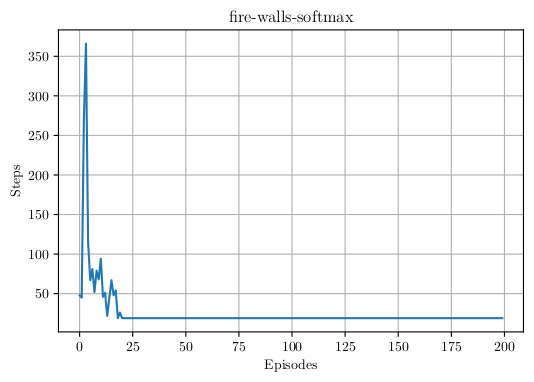

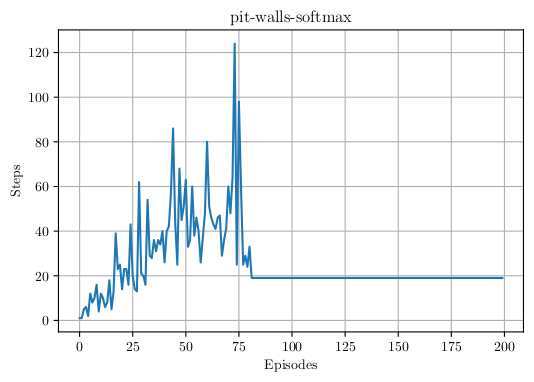

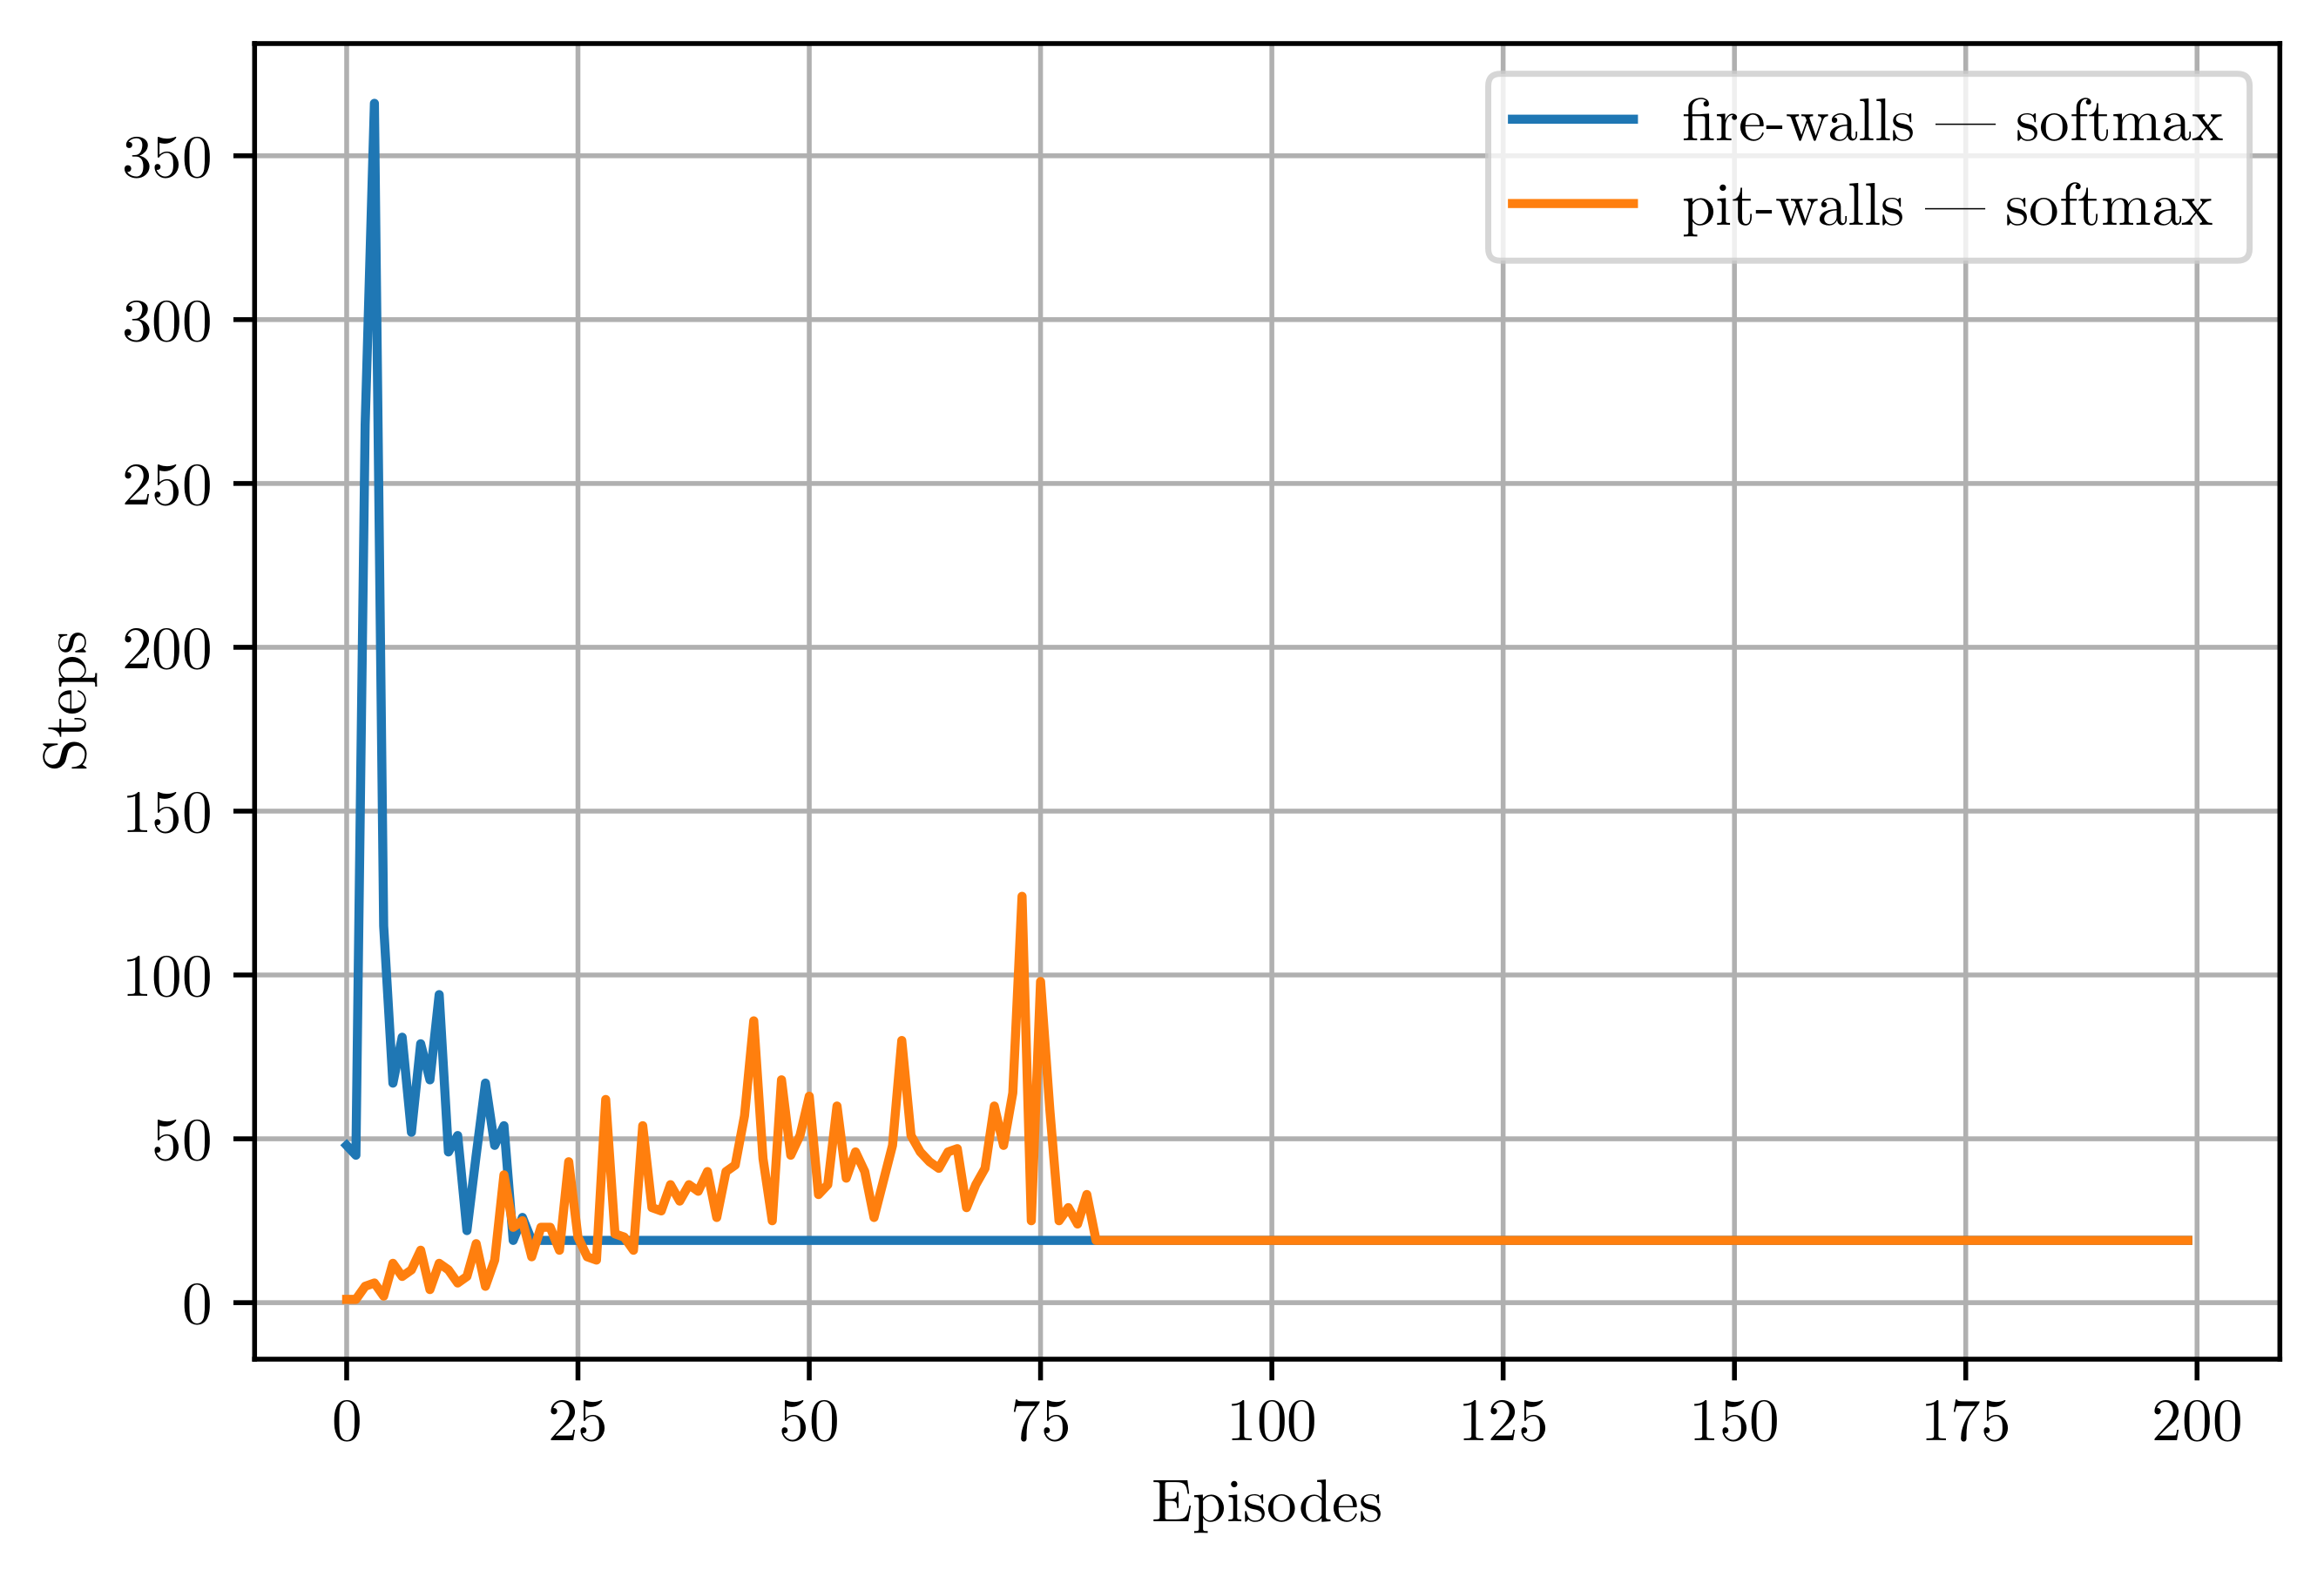

In [26]:
#Laberinto con paredes de fuego. Notar que se esta utilizando el metodo UCB1, y no e-greedy. Cambiar el parametro a method = 'e-greedy' si lo desea.
model_fire = Q_maze(rewards, episodes = n_iter, discount_rate = 0.9, alpha = 0.9, method = 'softmax', epsilon = 0.1, temperature=1, game='fire-walls') 
model_fire.train()

print('Modelo Laberinto con paredes de fuego Entrenado!')
print(f'El mejor camino para llegar a la meta comenzando desde {estado_inicio} es {model_fire.mejor_camino(estado_inicio)}\n')
model_fire.plot_steps_per_episode()


model_pit = Q_maze(rewards, episodes = n_iter, discount_rate = 0.9, alpha = 0.9, method = 'softmax', epsilon = 0.1, temperature=1, game='pit-walls')
model_pit.train()
model_pit.plot_steps_per_episode()


# print('Modelo Laberinto con fosas Entrenado!')
print('Modelo Laberinto con paredes de fuego Entrenado!')
print(f'El mejor camino para llegar a la meta comenzando desde {estado_inicio} es {model_pit.mejor_camino(estado_inicio)}\n')

# Graficos de convergencia

plot_steps_per_episode_comp([model_fire,model_pit])

print(min(model_pit.steps))
print(min(model_fire.steps))


### $\epsilon$-greedy

Modelo Laberinto con paredes de fuego Entrenado!
El mejor camino para llegar a la meta comenzando desde [1, 0] es [[1, 0], (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 2), (3, 1), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (4, 7), (3, 7), (2, 7), (2, 8)]

Modelo Laberinto con paredes de fuego Entrenado!
El mejor camino para llegar a la meta comenzando desde [1, 0] es [[1, 0], (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 2), (3, 1), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (4, 7), (3, 7), (2, 7), (2, 8)]



C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:299: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:299: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:316: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


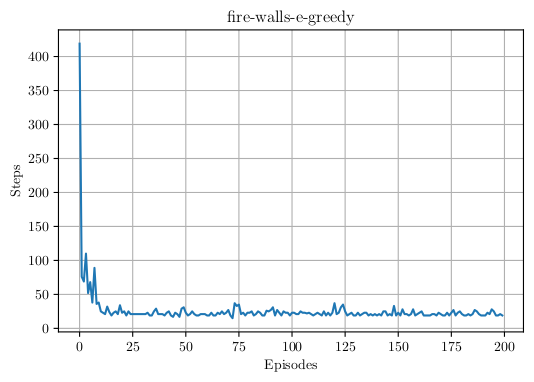

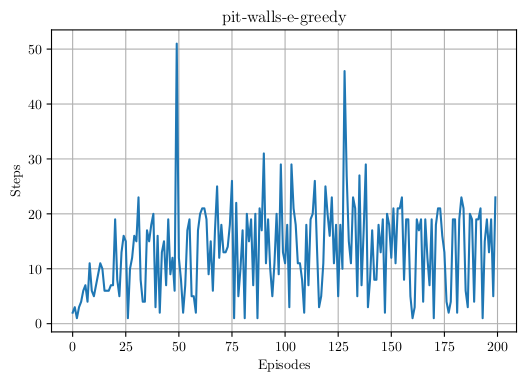

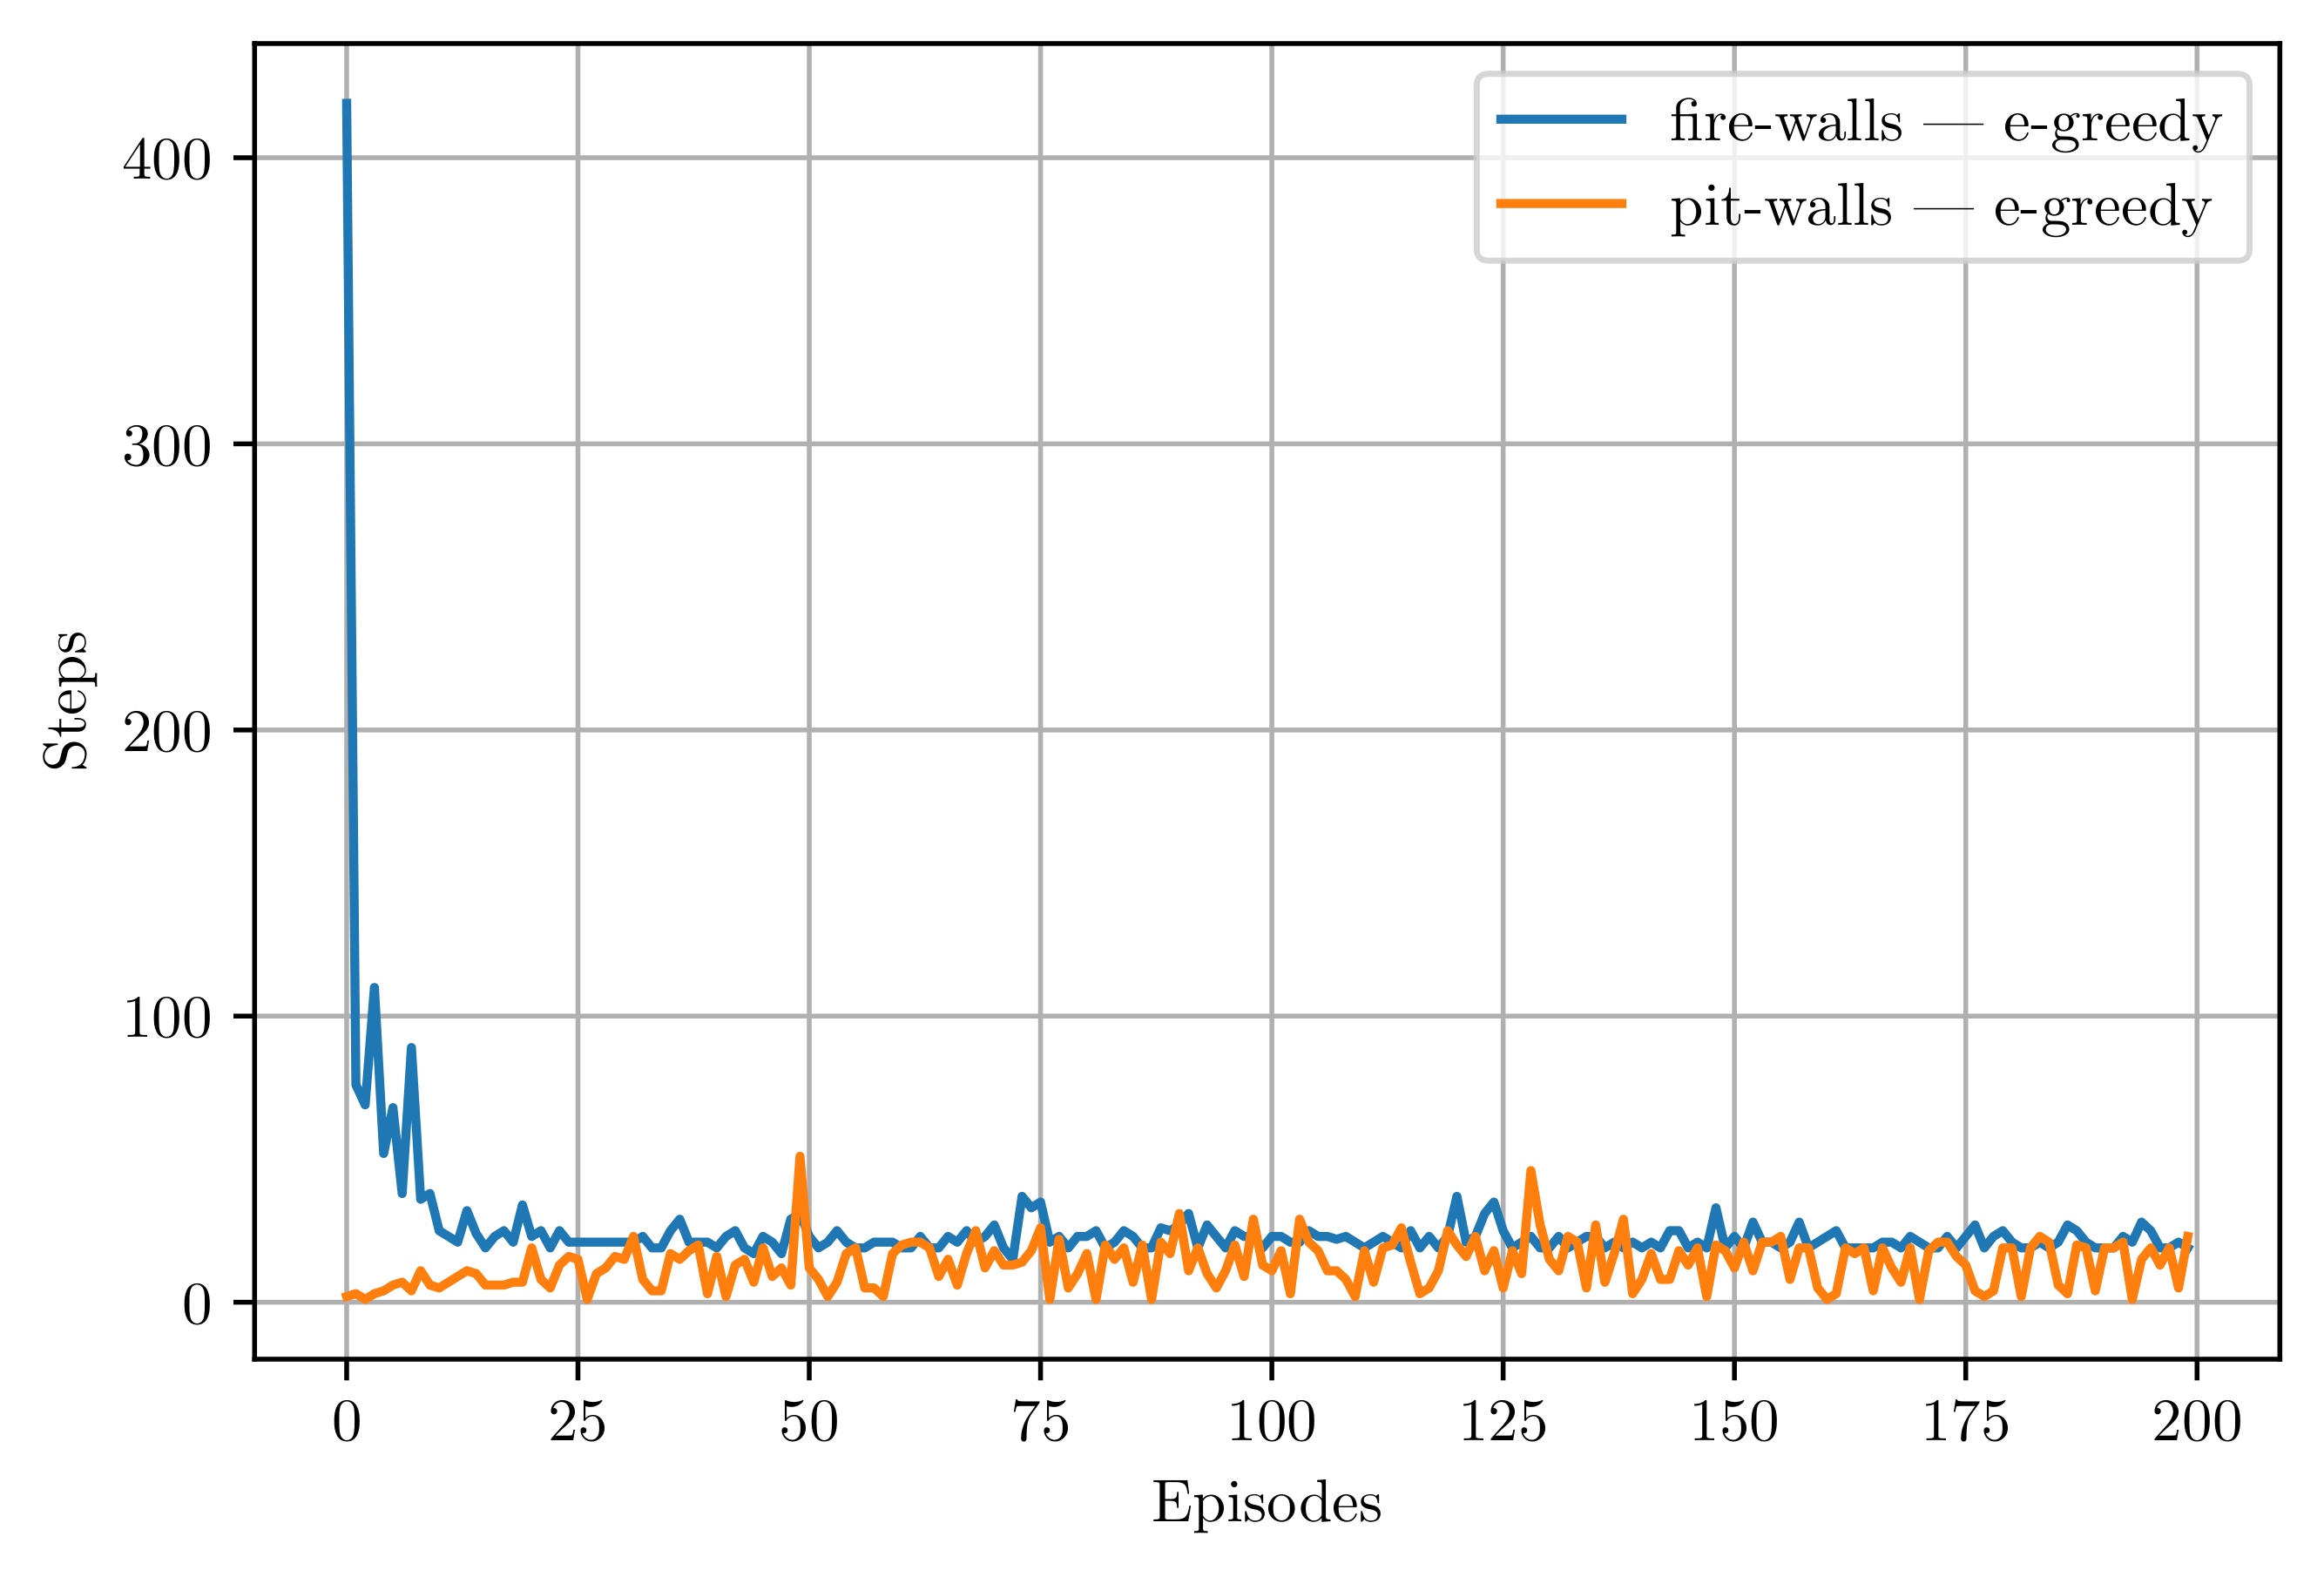

In [27]:
model_fire1 = Q_maze(rewards, episodes = n_iter, discount_rate = 0.9, alpha = 0.9, method = 'e-greedy', epsilon = 0.1, temperature=1, game='fire-walls') 
model_fire1.train()

print('Modelo Laberinto con paredes de fuego Entrenado!')
print(f'El mejor camino para llegar a la meta comenzando desde {estado_inicio} es {model_fire1.mejor_camino(estado_inicio)}\n')
model_fire1.plot_steps_per_episode()


model_pit1 = Q_maze(rewards, episodes = n_iter, discount_rate = 0.9, alpha = 0.9, method = 'e-greedy', epsilon = 0.1, temperature=1, game='pit-walls')
model_pit1.train()
model_pit1.plot_steps_per_episode()


# print('Modelo Laberinto con fosas Entrenado!')
print('Modelo Laberinto con paredes de fuego Entrenado!')
print(f'El mejor camino para llegar a la meta comenzando desde {estado_inicio} es {model_pit1.mejor_camino(estado_inicio)}\n')

# Graficos de convergencia

plot_steps_per_episode_comp([model_fire1,model_pit1])


### UCB1

Modelo Laberinto con paredes de fuego Entrenado!
El mejor camino para llegar a la meta comenzando desde [1, 0] es [[1, 0], (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 2), (3, 1), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (4, 7), (3, 7), (2, 7), (2, 8)]

Modelo Laberinto con paredes de fuego Entrenado!
El mejor camino para llegar a la meta comenzando desde [1, 0] es [[1, 0], (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 2), (3, 1), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (4, 7), (3, 7), (2, 7), (2, 8)]



C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:299: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:299: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:316: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


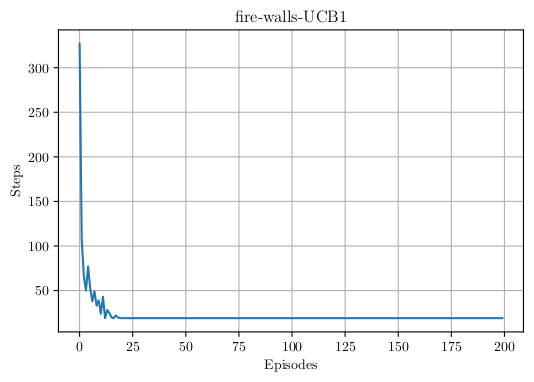

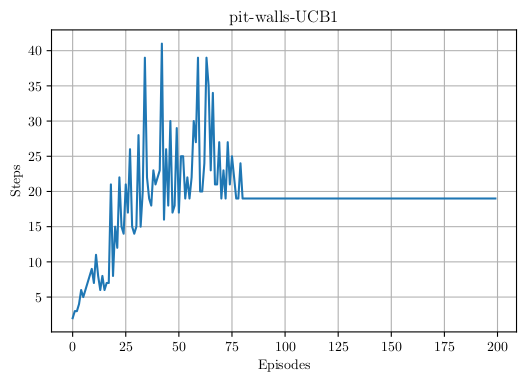

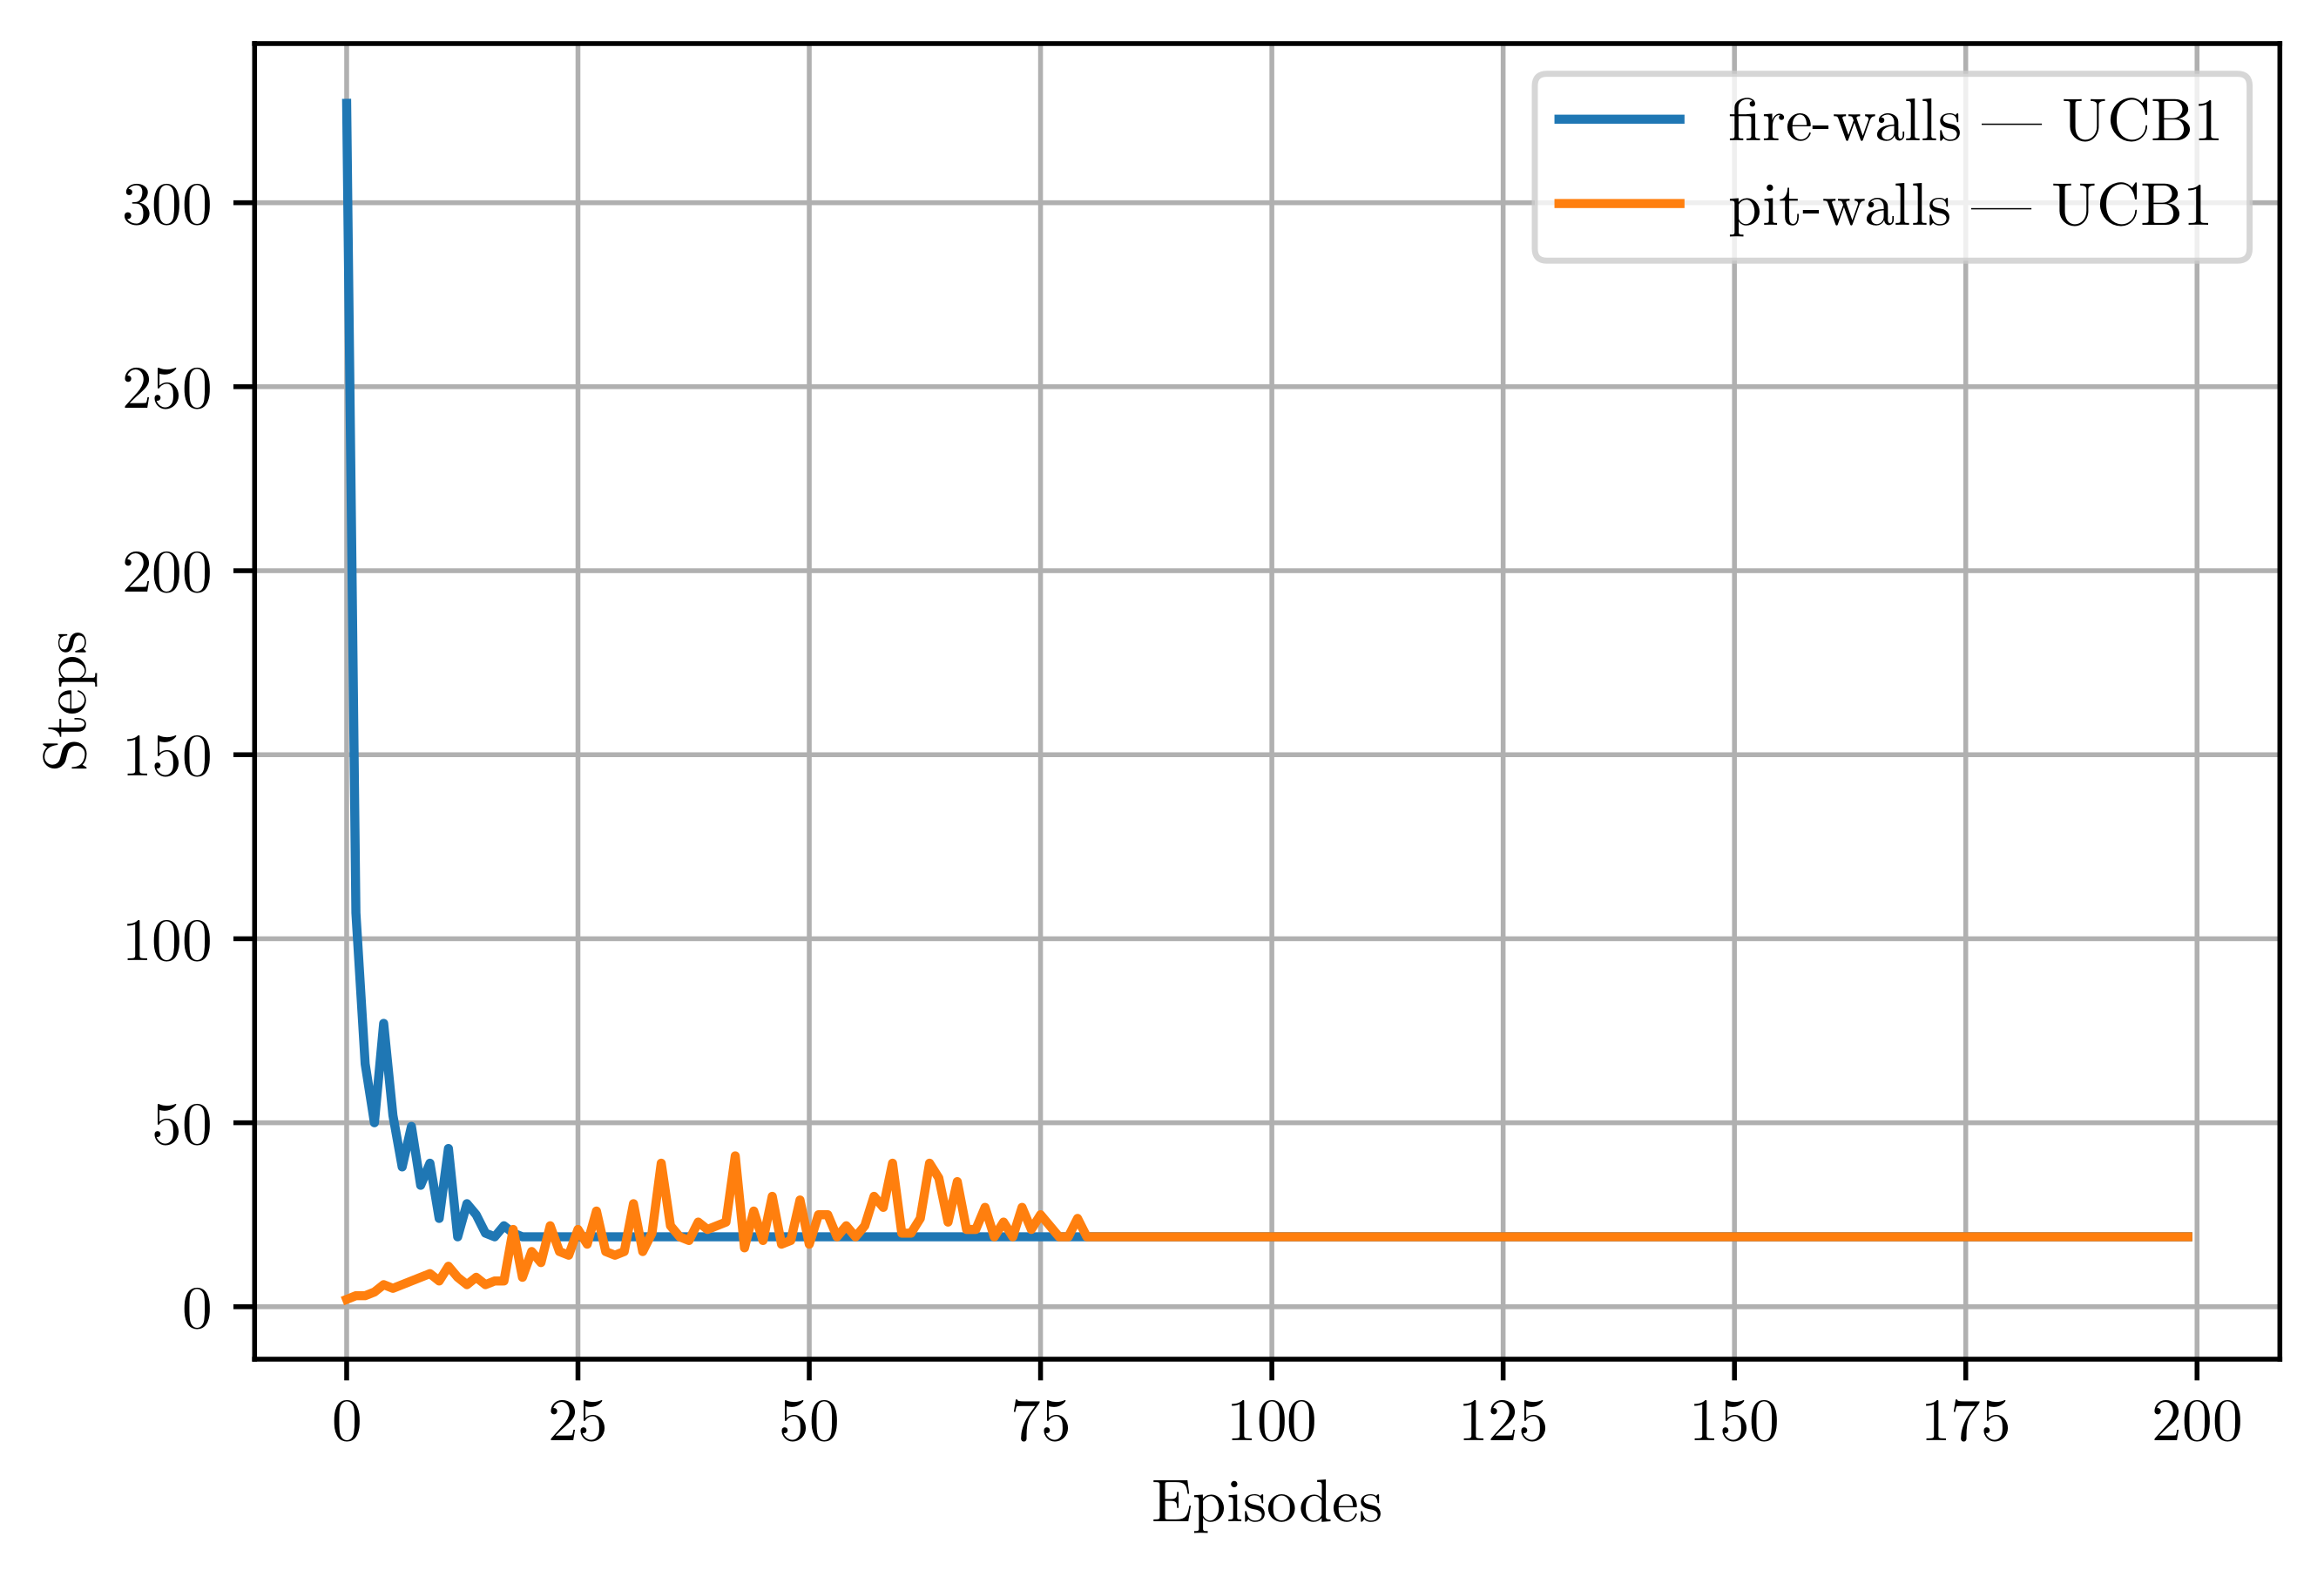

In [28]:
model_fire2 = Q_maze(rewards, episodes = n_iter, discount_rate = 0.9, alpha = 0.9, method = 'UCB1', epsilon = 0.1, temperature=1, game='fire-walls') 
model_fire2.train()

print('Modelo Laberinto con paredes de fuego Entrenado!')
print(f'El mejor camino para llegar a la meta comenzando desde {estado_inicio} es {model_fire2.mejor_camino(estado_inicio)}\n')
model_fire2.plot_steps_per_episode()


model_pit2 = Q_maze(rewards, episodes = n_iter, discount_rate = 0.9, alpha = 0.9, method = 'UCB1', epsilon = 0.1, temperature=1, game='pit-walls')
model_pit2.train()
model_pit2.plot_steps_per_episode()


# print('Modelo Laberinto con fosas Entrenado!')
print('Modelo Laberinto con paredes de fuego Entrenado!')
print(f'El mejor camino para llegar a la meta comenzando desde {estado_inicio} es {model_pit2.mejor_camino(estado_inicio)}\n')

# Graficos de convergencia

plot_steps_per_episode_comp([model_fire2,model_pit2])


C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:316: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


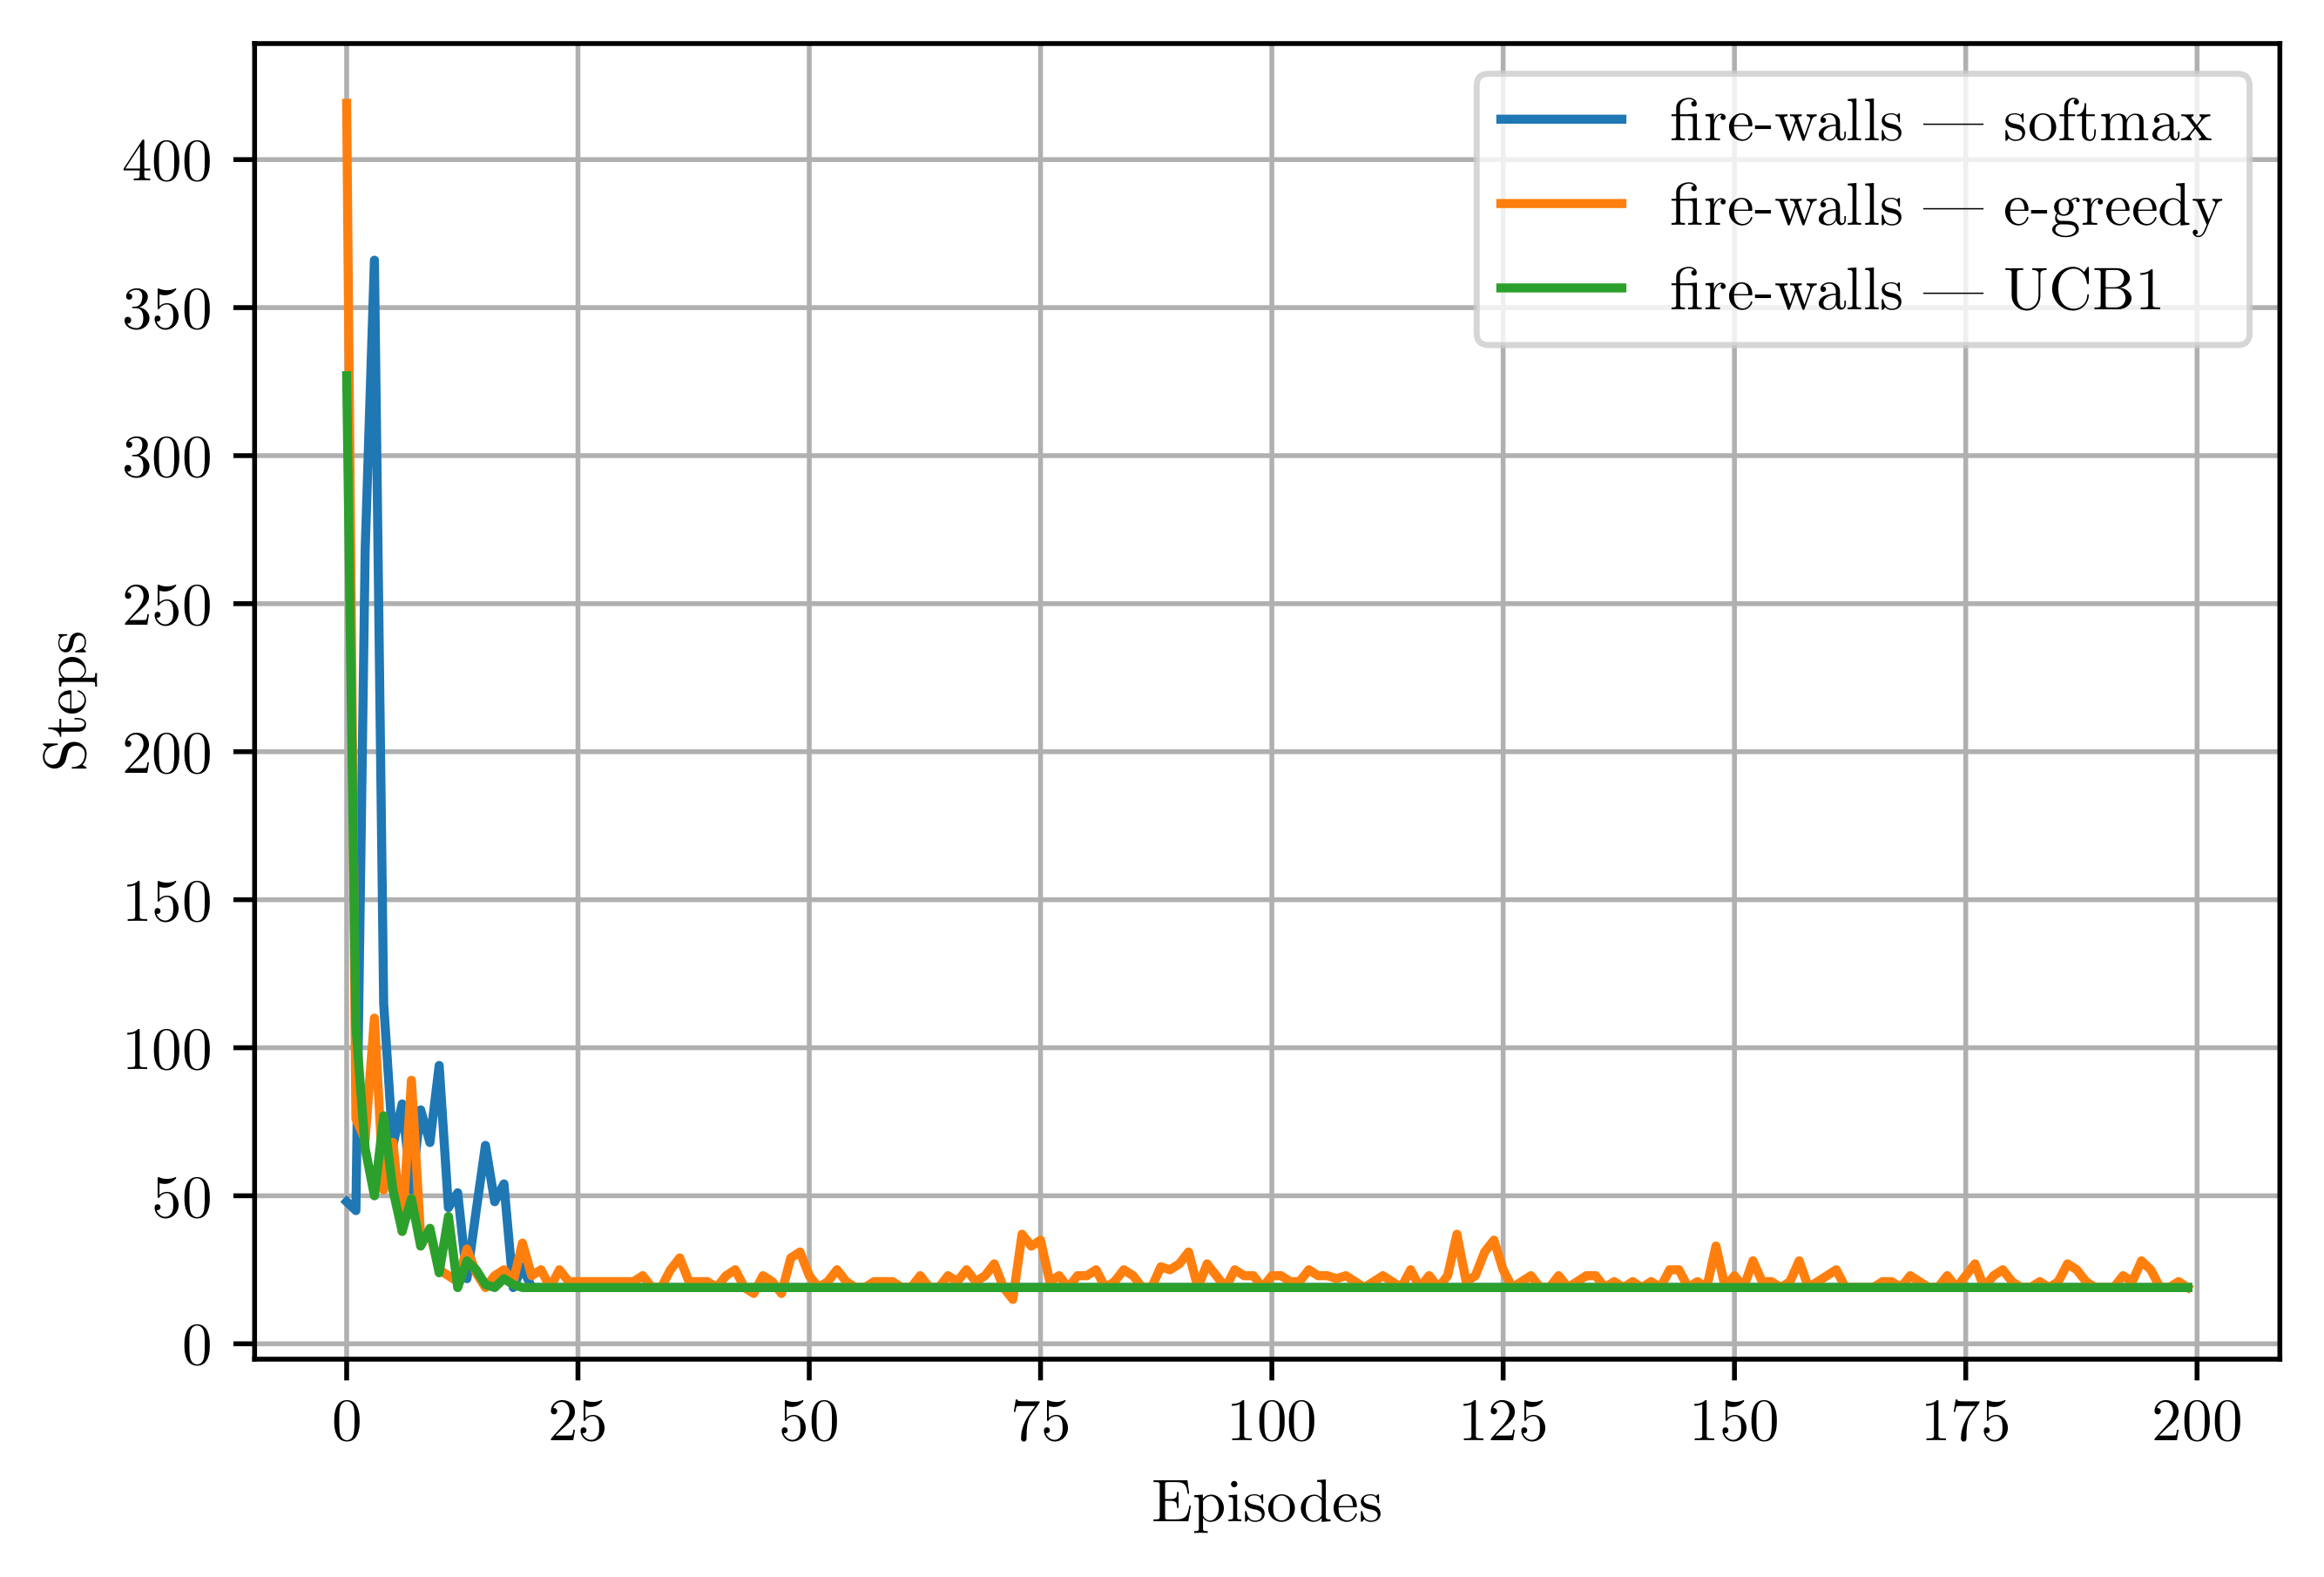

In [29]:
plot_steps_per_episode_comp([model_fire,model_fire1,model_fire2])

C:\Users\roloa\AppData\Local\Temp\ipykernel_25416\1254609765.py:316: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


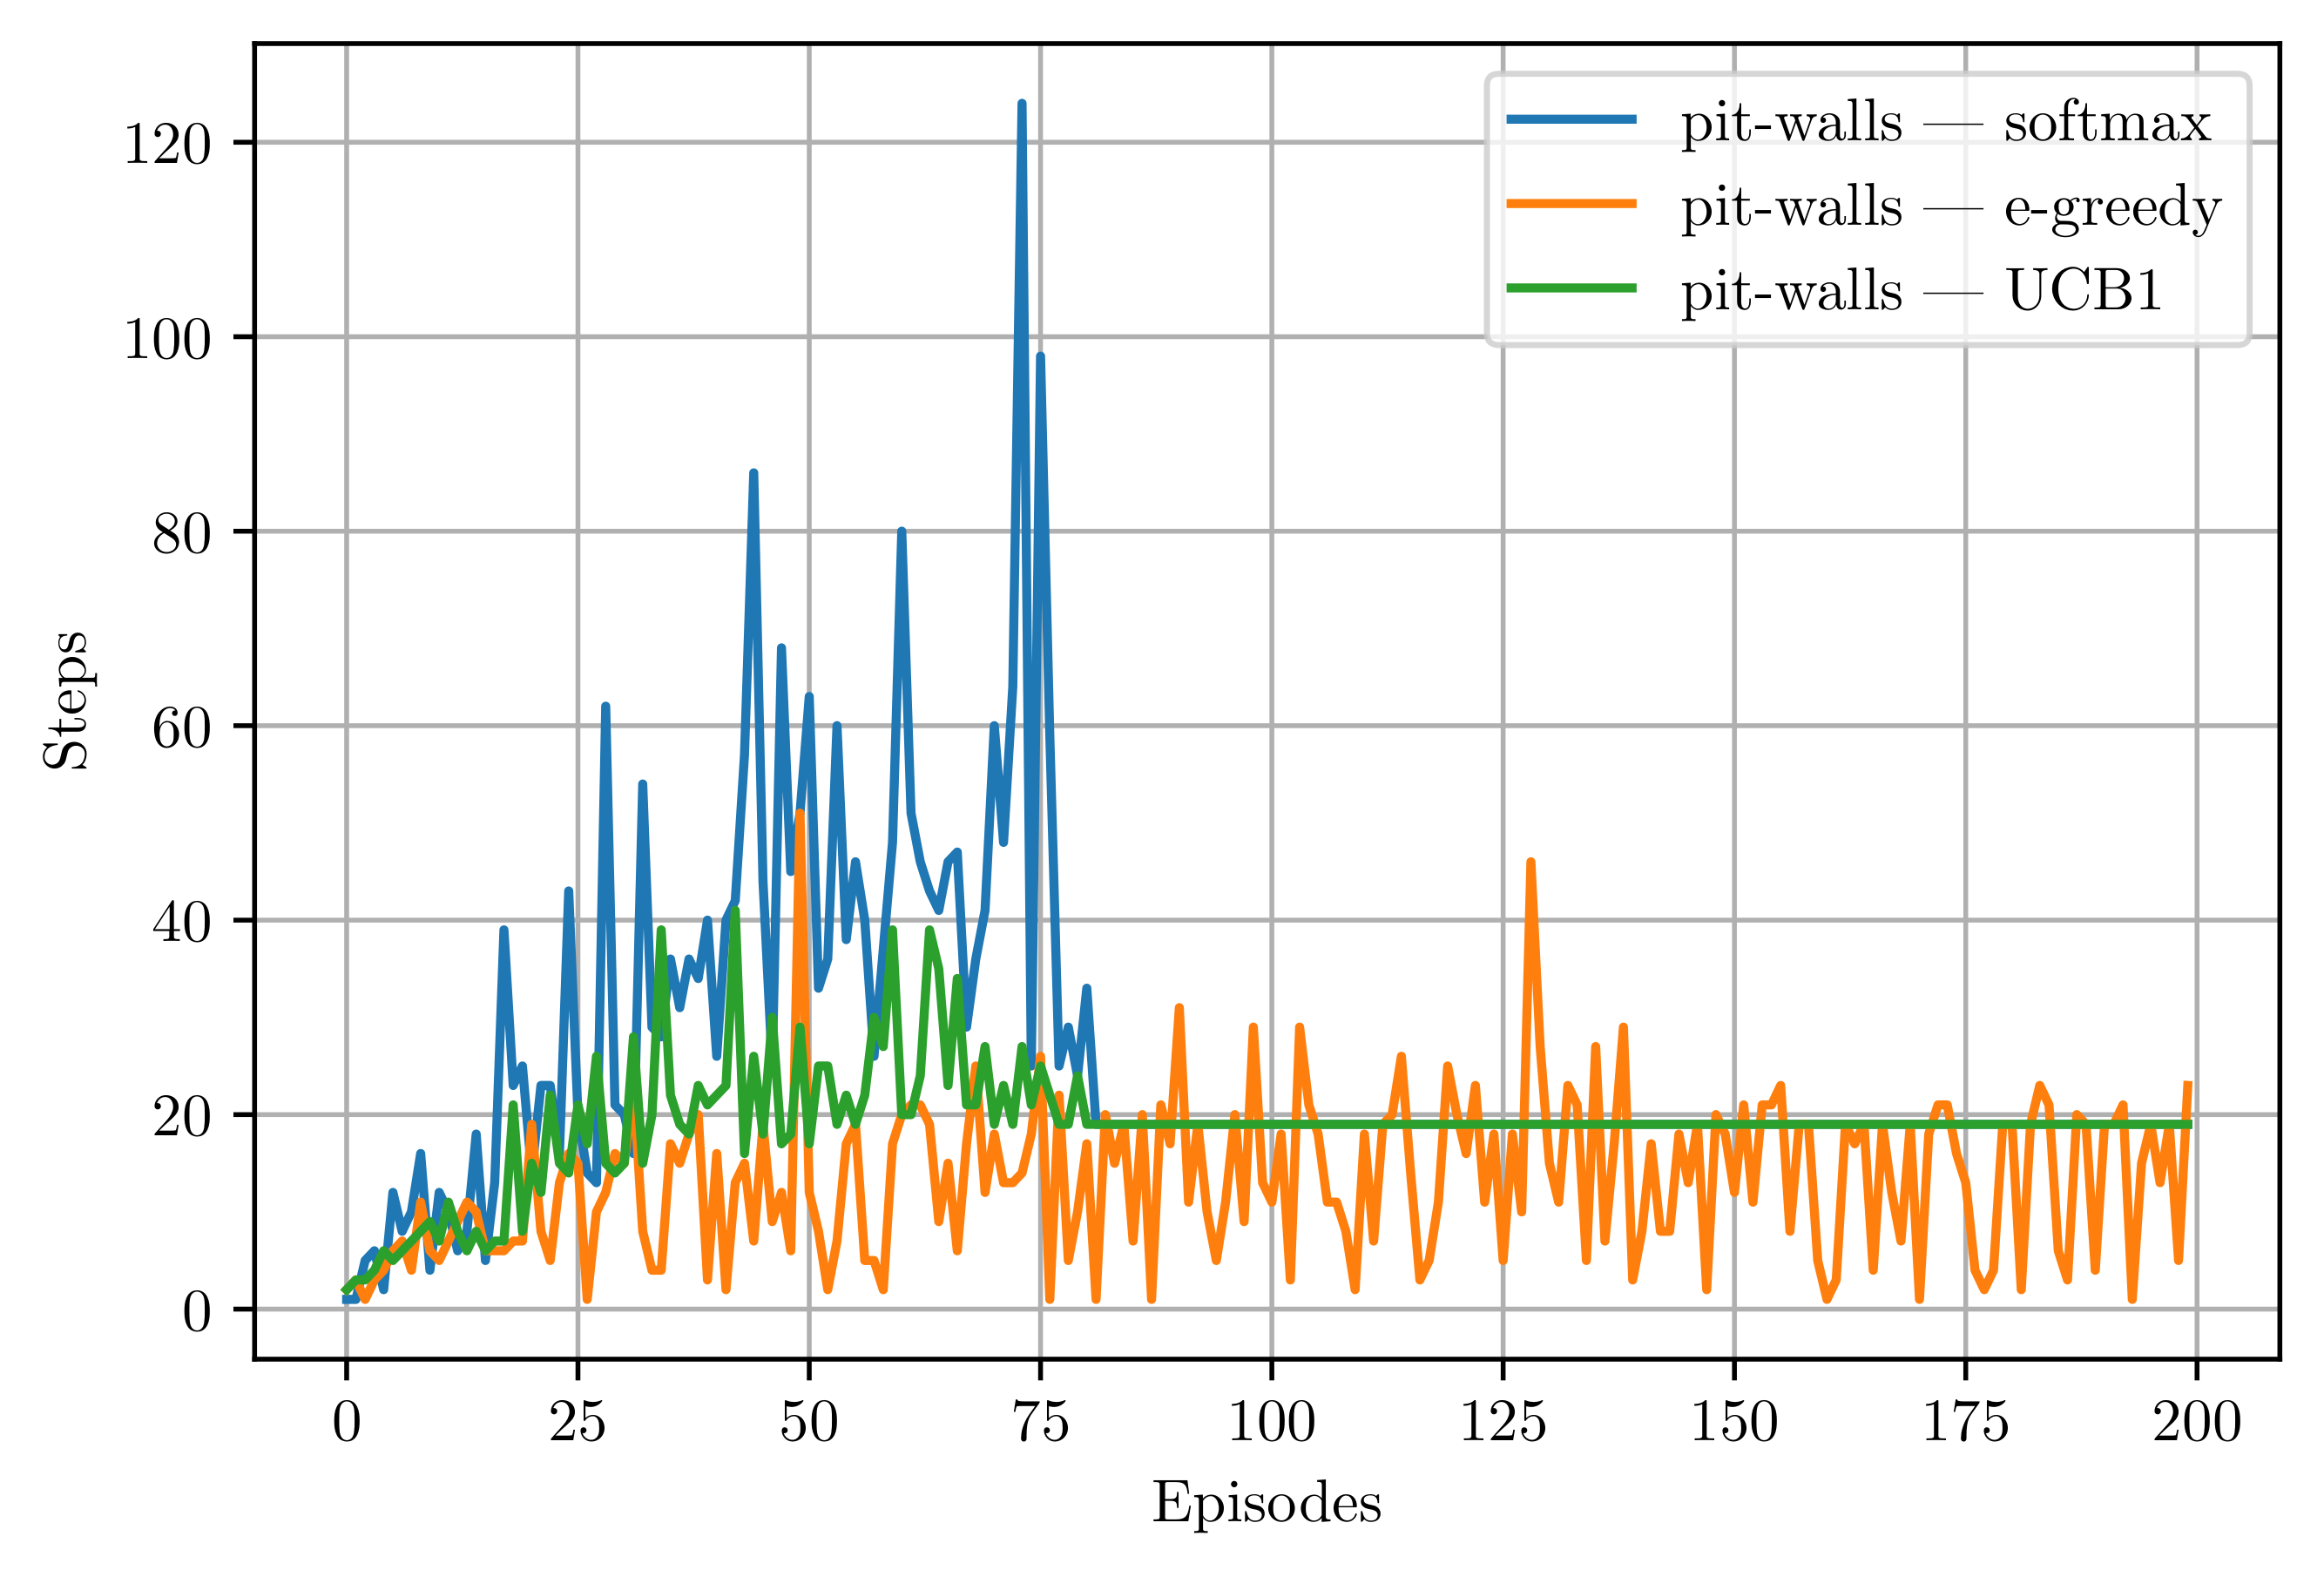

In [30]:
plot_steps_per_episode_comp([model_pit,model_pit1,model_pit2])